In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO

nwb_folder = '/root/capsule/data/s3_foraging_all_nwb'

Some util funcs

In [36]:
def moving_average(a, n=3) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
def plot_session_lightweight(data,   # choice_history, reward_history, p_reward
                             fitted_data=None, 
                             photostim=None,    # trial, power, s_type
                             valid_range=None,
                             smooth_factor=5, 
                             base_color='y', 
                             ax=None, 
                             vertical=False):
    # sns.reset_orig()
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 3) if not vertical else (3, 12), dpi=200)
        plt.subplots_adjust(left=0.1, right=0.8, bottom=0.05, top=0.8)

    if not vertical:
        gs = ax._subplotspec.subgridspec(2, 1, height_ratios=[1, 0.2], hspace=0.1)
        ax_1 = ax.get_figure().add_subplot(gs[0, 0])
        ax_2 = ax.get_figure().add_subplot(gs[1, 0])
        ax_1.get_shared_x_axes().join(ax_1, ax_2)
    else:
        gs = ax._subplotspec.subgridspec(1, 2, width_ratios=[0.2, 1], wspace=0.1)
        ax_1 = ax.get_figure().add_subplot(gs[0, 1])
        ax_2 = ax.get_figure().add_subplot(gs[0, 0])
        ax_1.get_shared_y_axes().join(ax_1, ax_2)
        
    with sns.plotting_context("notebook", font_scale=1):

        choice_history, reward_history, p_reward = data

        # == Fetch data ==
        n_trials = np.shape(choice_history)[1]

        p_reward_fraction = p_reward[1, :] / (np.sum(p_reward, axis=0))

        ignored_trials = np.isnan(choice_history[0])
        rewarded_trials = np.any(reward_history, axis=0)
        unrewarded_trials = np.logical_not(np.logical_or(rewarded_trials, ignored_trials))

        # == Choice trace ==
        # Rewarded trials
        xx = np.nonzero(rewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, rewarded_trials] - 0.5) * 1.4
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)], 
                '|' if not vertical else '_', color='black', markersize=10, markeredgewidth=2)

        # Unrewarded trials
        xx = np.nonzero(unrewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, unrewarded_trials] - 0.5) * 1.4
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                '|' if not vertical else '_', color='gray', markersize=6, markeredgewidth=1)

        # Ignored trials
        xx = np.nonzero(ignored_trials)[0] + 1
        yy = [1.1] * sum(ignored_trials)
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                'x', color='red', markersize=2, markeredgewidth=0.5, label='ignored')

        # Base probability
        xx = np.arange(0, n_trials) + 1
        yy = p_reward_fraction
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                color=base_color, label='base rew. prob.', lw=1.5)

        # Smoothed choice history
        y = moving_average(choice_history, smooth_factor) / moving_average(~np.isnan(choice_history), smooth_factor)
        x = np.arange(0, len(y)) + int(smooth_factor / 2) + 1
        ax_1.plot(*(x, y) if not vertical else [*(y, x)],
                linewidth=1.5, color='black', label='choice (smooth = %g)' % smooth_factor)
        
        # finished ratio
        if np.sum(np.isnan(choice_history)):
            x = np.arange(0, len(y)) + int(smooth_factor / 2) + 1
            y = moving_average(~np.isnan(choice_history), smooth_factor)
            ax_1.plot(*(x, y) if not vertical else [*(y, x)],
                    linewidth=0.8, color='m', alpha=1,
                    label='finished (smooth = %g)' % smooth_factor)
             
        # add valid ranage
        if valid_range is not None:
            add_range = ax_1.axhline if vertical else ax_1.axvline
            add_range(valid_range[0], color='m', ls='--', lw=1, label='motivation good')
            add_range(valid_range[1], color='m', ls='--', lw=1)
                
        # For each session, if any fitted_data
        if fitted_data is not None:
            ax_1.plot(np.arange(0, n_trials), fitted_data[1, :], linewidth=1.5, label='model')
        
        # == photo stim ==
        if photostim is not None:
            plot_spec_photostim = { 'after iti start': 'cyan',  
                                    'before go cue': 'cyan',
                                    'after go cue': 'green',
                                    'whole trial': 'blue'}
            
            trial, power, s_type = photostim
            x = trial
            y = np.ones_like(trial) + 0.4
            scatter = ax_1.scatter(
                                *(x, y) if not vertical else [*(y, x)],
                                s=power.astype(float)*2,
                                edgecolors=[plot_spec_photostim[t] for t in s_type]
                                  if any(s_type) else 'darkcyan',
                                marker='v' if not vertical else '<',
                                facecolors='none',
                                linewidth=0.5,
                                label='photostim')

        # p_reward    
        xx = np.arange(0, n_trials) + 1
        ll = p_reward[0, :]
        rr = p_reward[1, :]
        ax_2.plot(*(xx, rr) if not vertical else [*(rr, xx)],
                color='b', label='p_right', lw=1)
        ax_2.plot(*(xx, ll) if not vertical else [*(ll, xx)],
                color='r', label='p_left', lw=1)
        ax_2.legend(fontsize=5, ncol=1, loc='upper left', bbox_to_anchor=(0, 1))
        
        if not vertical:
            ax_1.set_yticks([0, 1])
            ax_1.set_yticklabels(['Left', 'Right'])
            ax_1.legend(fontsize=6, loc='upper left', bbox_to_anchor=(0.6, 1.3), ncol=2)
            ax_1.set_xticks([])

            sns.despine(trim=True, bottom=True, ax=ax_1)
            sns.despine(trim=True, ax=ax_2)
        else:
            ax_1.set_xticks([0, 1])
            ax_1.set_xticklabels(['Left', 'Right'])
            ax_1.invert_yaxis()
            ax_1.legend(fontsize=6, loc='upper left', bbox_to_anchor=(0, 1.05), ncol=2)
            ax_1.set_yticks([])

            sns.despine(trim=True, left=True, ax=ax_1)
            sns.despine(trim=True, ax=ax_2)


        # ax_2.set(ylim=(0, 1))
    
    # ax.set_xlim(0,300)

    # fig.tight_layout()
    ax_2.set(xlabel='Trial number')
    ax.remove()

    return ax_1.get_figure(), [ax_1, ax_2]

## Behavior meta data

### This master dataframe is the same as the one at https://foraging-behavior-browser.streamlit.app/, which is updated everyday.

In [6]:
df_sessions = pd.read_pickle(nwb_folder + '/df_sessions.pkl')
df_sessions.sort_values('session_date', ascending=False)

,session_date,h2o,session,subject_id,finished_trials,foraging_eff,photostim,task,rig,start_weight,...,valid_trial_start,valid_trial_end,valid_ratio,photostim_trial_ratio,headbar,age_in_weeks,session_length_in_hrs,relative_weight,water_total,water_per_trial_in_uL
3509,2023-05-08,XY_25,49,656492,560,0.8672,yes,coupled_block_baiting,AIND-Tower-3,28.00,...,7.0,564.0,0.728460,0.224543,allen_headbar_at_allen,26.857143,1.174104,0.875000,1.50,1.351351
3681,2023-05-08,KH_FB82,18,664641,644,0.4884,,coupled_block_baiting,AIND-Tower-6,22.70,...,1.0,825.0,0.910596,NaN,allen_headbar_at_allen,17.142857,1.747070,0.933921,1.50,0.840336
3395,2023-05-08,XY_23,52,656489,434,0.7527,yes,coupled_block_baiting,AIND-Tower-3,26.20,...,1.0,541.0,0.944154,0.244328,allen_headbar_at_allen,26.857143,1.160296,0.900763,1.50,2.919708
3698,2023-05-08,KH_FB84,25,664644,551,0.6442,,decoupled_no_baiting,AIND-Tower-2,22.45,...,1.0,712.0,0.905852,NaN,allen_headbar_at_allen,17.142857,1.495302,0.979955,1.50,1.612903
3643,2023-05-05,KH_FB85,23,663373,697,0.6137,,decoupled_no_baiting,AIND-Tower-7,26.90,...,1.0,751.0,0.965296,NaN,allen_headbar_at_allen,18.000000,1.390375,0.840149,1.50,1.731602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2019-06-26,FOR04,2,453476,516,0.5698,,coupled_block_baiting,Training-Tower-2,21.30,...,10.0,598.0,0.965574,NaN,janelia_headbar_at_janelia,10.428571,1.050609,0.765258,0.55,1.740506
193,2019-06-25,FOR02,1,453475,291,0.5842,,coupled_block_baiting,Training-Tower-2,20.60,...,5.0,542.0,0.943860,NaN,janelia_headbar_at_janelia,10.285714,0.829406,0.762136,0.40,1.809955
221,2019-06-25,FOR04,1,453476,223,0.5695,,coupled_block_baiting,Training-Tower-2,21.30,...,19.0,406.0,0.795082,NaN,janelia_headbar_at_janelia,10.285714,1.170838,0.784038,0.30,1.818182
250,2019-06-25,FOR03,1,453477,147,0.6667,,coupled_block_baiting,Training-Tower-2,18.40,...,1.0,334.0,0.822660,NaN,janelia_headbar_at_janelia,10.285714,0.730702,0.777174,0.30,1.886792


## Load one session

In [24]:
nwb_file = '/XY_23/XY_23_20230508_52.nwb'

io = NWBHDF5IO(nwb_folder + nwb_file, mode='r')
nwb = io.read()

In [25]:
nwb

root pynwb.file.NWBFile at 0x139930491640272
Fields:
  acquisition: {
    BehavioralEvents <class 'pynwb.behavior.BehavioralEvents'>
  }
  experiment_description: moving lickports, delay period, early lick punishment, sound GO cue then free choice
  experimenter: ['LucasK']
  file_create_date: [datetime.datetime(2023, 5, 10, 6, 12, 6, 903472, tzinfo=tzutc())]
  identifier: XY_23_20230508_151310_s52
  institution: Janelia Research Campus / Allen Institute
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <HDF5 dataset "keywords": shape (0,), type "|O">
  related_publications: ['']
  session_description: 1st no opto: 2nd opto
  session_start_time: 2023-05-08 15:13:10+00:00
  subject: subject pynwb.file.Subject at 0x139930428383776
Fields:
  date_of_birth: 2022-11-01 00:00:00+00:00
  description: XY_23
  sex: M
  species: mus musculus
  subject_id: 656489

  timestamps_reference_time: 2023-05-08 15:13:10+00:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'

## Behavioral trials

In [27]:
df_trials = nwb.trials.to_dataframe()
df_trials

,start_time,stop_time,trial,task,task_protocol,early_lick,outcome,auto_water,free_water,choice,...,photostim_power,photostim_on_to_go_cue,photostim_off_to_go_cue,photostim_duration,photostim_ramping_down,photostim_bpod_timer_align_to,photostim_bpod_timer_offset,left_action_value,right_action_value,rpe
id,,,,,,,,,,,,,,,,,,,,,
0,-0.5338,9.6358,1,foraging,100,early,hit,0,0,right,...,0.0,0.0000,0.0000,0.0000,0.0,null,0,NaN,NaN,NaN
1,9.6358,14.2097,2,foraging,100,no early,miss,0,0,right,...,0.0,0.0000,0.0000,0.0000,0.0,null,0,NaN,NaN,NaN
2,14.2097,19.5924,3,foraging,100,no early,miss,0,0,right,...,0.0,0.0000,0.0000,0.0000,0.0,null,0,NaN,NaN,NaN
3,19.5924,26.9050,4,foraging,100,early,miss,0,0,right,...,0.0,0.0000,0.0000,0.0000,0.0,null,0,NaN,NaN,NaN
4,26.9050,32.1074,5,foraging,100,no early,miss,0,0,right,...,0.0,0.0000,0.0000,0.0000,0.0,null,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,4133.8575,4143.7612,569,foraging,100,no early,hit,0,0,right,...,0.0,0.0000,0.0000,0.0000,0.0,null,0,NaN,NaN,NaN
569,4143.7612,4157.0808,570,foraging,100,early,miss,0,0,right,...,2.6,0.0014,1.3486,1.3472,0.0,after go cue,0,NaN,NaN,NaN
570,4157.0808,4167.3115,571,foraging,100,no early,ignore,0,0,null,...,0.0,0.0000,0.0000,0.0000,0.0,null,0,NaN,NaN,NaN


### Trial view

<ipython-input-36-9eb85deb0729>:24: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_1.get_shared_x_axes().join(ax_1, ax_2)
<ipython-input-36-9eb85deb0729>:70: RuntimeWarning: invalid value encountered in divide
  y = moving_average(choice_history, smooth_factor) / moving_average(~np.isnan(choice_history), smooth_factor)


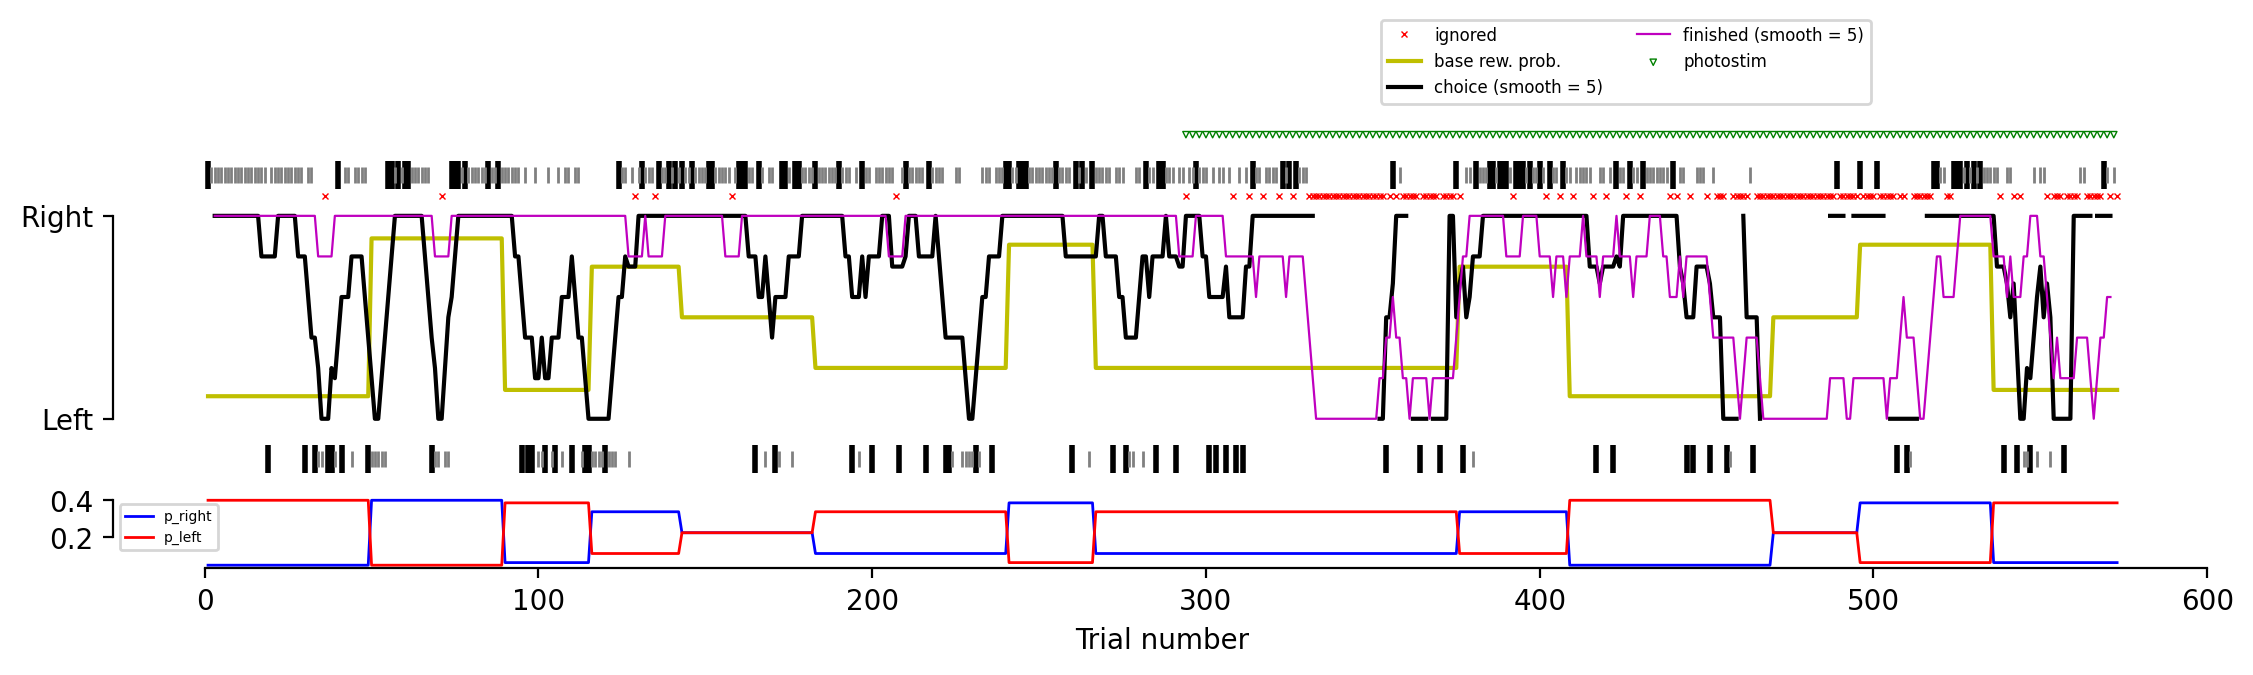

In [37]:
# Reformat data
_choice_history = df_trials.choice.values
choice_history = np.array([{'left': 0, 'right': 1, 'null': np.nan}[c] for c in _choice_history])

_reward = df_trials.outcome
reward_history = np.zeros([2, len(_reward)])  # .shape = (2, N trials)
for c in (0, 1):
    reward_history[c, choice_history==c] = (_reward[choice_history==c] == 'hit').astype(int)
    
p_reward = np.vstack([df_trials.left_reward_prob, df_trials.right_reward_prob])

# photostim
photostim_trials = df_trials.photostim_power > 0
photostim = [df_trials.trial[photostim_trials], df_trials.photostim_power[photostim_trials], df_trials.photostim_bpod_timer_align_to[photostim_trials]]

# Plot session
fig, ax = plot_session_lightweight([np.array([choice_history]), reward_history, p_reward], photostim=photostim)

## Behavioral events

#### Here is the trial structure

1. In the inter-trial-interval (ITI), lickports are far from the mice.
2. (Some sessions) at the trial start, lickports move forward to the "ready" position (`lickportready`, ephys only)
3. A "no-lick period" starts (relatively short in my experiments, ~0.2-0.5 sec)
4. In the "no-lick period", if there is a "early lick", add a 2 sec timeout, and go back to `3` (still in the same trial)
5. If there is no early lick, deliver a `go_cue` sound, and a "response window" starts (typically 5 sec)
6. If there is any lick in the response window:
    <br>i. The first lick after the go cue is considered as `choice`. Deliver reward if a reward exists on the chosen lickport ("hit"), otherwise, "miss"
   <br>ii. If there is no more lick in any 1-second window, go to `8`. (In other words, if the mouse keeps licking, the trial will become very long)
   <br>iii. If there is any lick to the other lickport than the "choice", this trial is "double-dipped". In part of experiments, the trial will be terminated (go to `8`) to discourage double-dipping.
7. If there is no lick in the response window, this trial is an "ignore" trial, and go to `8`.
8. `trialend`: lickports are retracted and IT starts.## Behavioral trials

In [30]:
behav_events = nwb.acquisition['BehavioralEvents']
behav_events

BehavioralEvents pynwb.behavior.BehavioralEvents at 0x139930428383584
Fields:
  time_series: {
    choice <class 'pynwb.base.TimeSeries'>,
    delay <class 'pynwb.base.TimeSeries'>,
    doubledip <class 'pynwb.base.TimeSeries'>,
    go <class 'pynwb.base.TimeSeries'>,
    laserLdown <class 'pynwb.base.TimeSeries'>,
    laserLoff <class 'pynwb.base.TimeSeries'>,
    laserLon <class 'pynwb.base.TimeSeries'>,
    left_lick <class 'pynwb.base.TimeSeries'>,
    reward <class 'pynwb.base.TimeSeries'>,
    right_lick <class 'pynwb.base.TimeSeries'>,
    trialend <class 'pynwb.base.TimeSeries'>
  }

For example, get all go cue times (all times are relative to the first trial start of a session, in sec)

In [31]:
go_cue = behav_events['go'].timestamps[:]
print(go_cue[:20])
len(go_cue)

[  5.5157  12.719   18.2275  24.6772  30.7804  35.1772  39.4041  52.3391
  58.156   62.6499  69.2914  79.0224  83.3274  87.1776  91.3813  95.7574
  99.9148 105.1851 114.467  119.9647]


573

## Time view

[Text(0.5, 0, 'Time (sec)')]

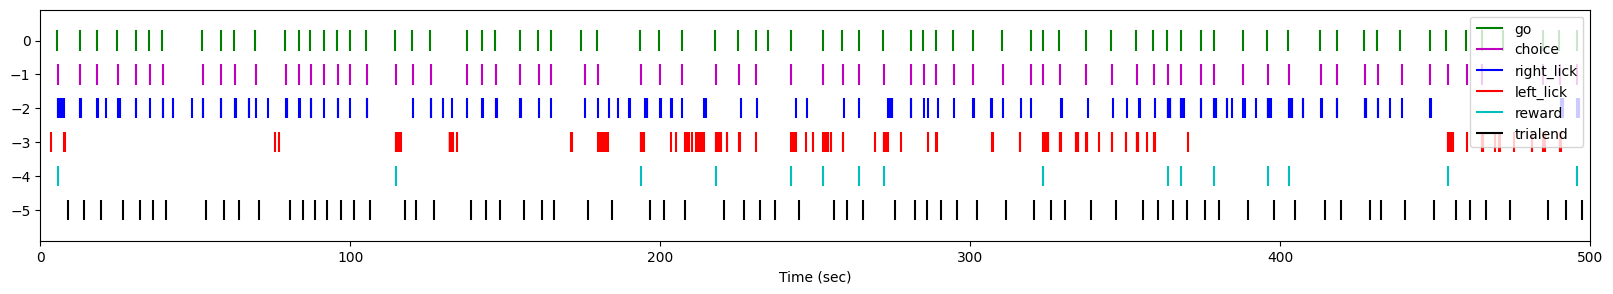

In [38]:
event_color_map = {'go': 'g', 'choice': 'm', 'right_lick': 'b', 'left_lick': 'r', 'reward': 'c', 'trialend': 'k'}
event_times = [behav_events[x].timestamps[:] for x in event_color_map]

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
ax.eventplot(event_times, colors=list(event_color_map.values()), linelengths=0.6, lineoffsets=-1)
ax.legend(event_color_map)
ax.set_xlim((0, 500))
ax.set(xlabel='Time (sec)')